In [1]:
import matplotlib.pyplot as plt

In [2]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import os
import time

## I. Parse Text Sources
First we'll load our text sources and create our vocabulary lists and encoders.

There are ways we could do this in pure python, but using the tensorflow data structures and libraries allow us to keep things super-optimized.

In [3]:
# Load file data
path_to_file = tf.keras.utils.get_file('austen.txt', 'https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/austen/austen.txt')
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print('Length of text: {} characters'.format(len(text)))

Length of text: 4906787 characters


In [4]:
# Verify the first part of our data
print(text[:200])

VOLUME I



CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings of
existence; and had lived nearly twenty-


In [5]:
# Now we'll get a list of the unique characters in the file. This will form the
# vocabulary of our network. There may be some characters we want to remove from this
# set as we refine the network.
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))
print(vocab)

86 unique characters
['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£', 'é', '‘', '’', '“', '”']


In [6]:
# Next, we'll encode encode these characters into numbers so we can use them
# with our neural network, then we'll create some mappings between the characters
# and their numeric representations
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True)

# Here's a little helper function that we can use to turn a sequence of ids
# back into a string:
# turn them into a string:
def text_from_ids(ids):
  joinedTensor = tf.strings.reduce_join(chars_from_ids(ids), axis=-1)
  return joinedTensor.numpy().decode("utf-8")

In [7]:
# Now we'll verify that they work, by getting the code for "A", and then looking
# that up in reverse
testids = ids_from_chars(["T", "r", "u", "t", "h"])
testids

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([45, 72, 75, 74, 62], dtype=int64)>

In [8]:
chars_from_ids(testids)

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'T', b'r', b'u', b't', b'h'], dtype=object)>

In [9]:
testString = text_from_ids( testids )
testString

'Truth'

## II. Construct our training data
Next we need to construct our training data by building sentence chunks. Each chunk will consist of a sequence of characters and a corresponding "next sequence" of the same length showing what would happen if we move forward in the text. This "next sequence" becomes our target variable.

For example, if this were our text:

> It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

And our sequence length was 10 with a step size of 1, our first chunk would be:

* Sequence: `It is a tr`
* Next Sequence: `t is a tru`

Our second chunk would be:

* Sequence: `t is a tru`
* Next Word: ` is a trut`



In [10]:
# First, create a stream of encoded integers from our text
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(4906787,), dtype=int64, numpy=array([47, 40, 37, ..., 30, 39, 29], dtype=int64)>

In [11]:
# Now, convert that into a tensorflow dataset
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [12]:
# Finally, let's batch these sequences up into chunks for our training
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

# This function will generate our sequence pairs:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

# Call the function for every sequence in our list to create a new dataset
# of input->target pairs
dataset = sequences.map(split_input_target)

In [13]:
# Verify our sequences
for input_example, target_example in  dataset.take(1):
    print("Input: ", text_from_ids(input_example))
    print("--------")
    print("Target: ", text_from_ids(target_example))

Input:  VOLUME I



CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happ
--------
Target:  OLUME I



CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy


In [14]:
# Finally, we'll randomize the sequences so that we don't just memorize the books
# in the order they were written, then build a new streaming dataset from that.
# Using a streaming dataset allows us to pass the data to our network bit by bit,
# rather than keeping it all in memory. We'll set it to figure out how much data
# to prefetch in the background.

BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## III. Build the model

Next, we'll build our model. Up until this point, you've been using the Keras symbolic, or imperative API for creating your models. Doing something like:

    model = tf.keras.models.Sequentla()
    model.add(tf.keras.layers.Dense(80, activation='relu))
    etc...

However, tensorflow has another way to build models called the Functional API, which gives us a lot more control over what happens inside the model. You can read more about [the differences and when to use each here](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html).

We'll use the functional API for our RNN in this example. This will involve defining our model as a custom subclass of `tf.keras.Model`.

If you're not familiar with classes in python, you might want to review [this quick tutorial](https://www.w3schools.com/python/python_classes.asp), as well as [this one on class inheritance](https://www.w3schools.com/python/python_inheritance.asp).

Using a functional model is important for our situation because we're not just training it to predict a single character for a single sequence, but as we make predictions with it, we need it to remember those predictions as use that memory as it makes new predictions.


In [15]:
# Create our custom model. Given a sequence of characters, this
# model's job is to predict what character should come next.
class AustenTextModel(tf.keras.Model):

  # This is our class constructor method, it will be executed when
  # we first create an instance of the class
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)

    # Our model will have three layers:

    # 1. An embedding layer that handles the encoding of our vocabulary into
    #    a vector of values suitable for a neural network
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # 2. A GRU layer that handles the "memory" aspects of our RNN. If you're
    #    wondering why we use GRU instead of LSTM, and whether LSTM is better,
    #    take a look at this article: https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm
    #    then consider trying out LSTM instead (or in addition to!)
    self.lstm_1 = tf.keras.layers.LSTM(rnn_units, return_sequences=True, return_state=True)

    # 3. Our output layer that will give us a set of probabilities for each
    #    character in our vocabulary.
    self.dense = tf.keras.layers.Dense(vocab_size)

  # This function will be executed for each epoch of our training. Here
  # we will manually feed information from one layer of our network to the
  # next.
  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs

    # 1. Feed the inputs into the embedding layer, and tell it if we are
    #    training or predicting
    x = self.embedding(x, training=training)

    # 2. If we don't have any state in memory yet, get the initial random state
    #    from our GRUI layer.
    if states is None:
      states = self.lstm_1.get_initial_state(x)

    # 3. Now, feed the vectorized input along with the current state of memory
    #    into the gru layer.
    ##get returns from first lstm layer (I'm guessing that returned states are state_h then state_c)
    x, state_h, state_c = self.lstm_1(x, initial_state=states, training=training)

    ##package states into single states var
    states = [state_h, state_c]

    # 4. Finally, pass the results on to the dense layer
    x = self.dense(x, training=training)

    # 5. Return the results
    if return_state:
      return x, states
    else:
      return x

In [16]:
# Create an instance of our model
vocab_size=len(ids_from_chars.get_vocabulary())
embedding_dim = 256
rnn_units = 1024

model = AustenTextModel(vocab_size, embedding_dim, rnn_units)

In [17]:
# Verify the output of our model is correct by running one sample through
# This will also compile the model for us. This step will take a bit.
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 87) # (batch_size, sequence_length, vocab_size)


In [18]:
# Now let's view the model summary
model.summary()

Model: "austen_text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  22272     
                                                                 
 lstm (LSTM)                 multiple                  5246976   
                                                                 
 dense (Dense)               multiple                  89175     
                                                                 
Total params: 5358423 (20.44 MB)
Trainable params: 5358423 (20.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## IV. Train the model

For our purposes, we'll be using [categorical cross entropy](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) as our loss function*. Also, our model will be outputting ["logits" rather than normalized probabilities](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow), because we'll be doing further transformations on the output later.


\* Note that since our model deals with integer encoding rather than one-hot encoding, we'll specifically be using [sparse categorical cross entropy](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other).

In [39]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)

history = model.fit(dataset, epochs=10)

Epoch 1/10
759/759 [==============================] - 2710s 4s/step - loss: 0.6851
Epoch 2/10
759/759 [==============================] - 3240s 4s/step - loss: 0.6753
Epoch 3/10
759/759 [==============================] - 3228s 4s/step - loss: 0.6698
Epoch 4/10
759/759 [==============================] - 3232s 4s/step - loss: 0.6643
Epoch 5/10
759/759 [==============================] - 3240s 4s/step - loss: 0.6590
Epoch 6/10
759/759 [==============================] - 2653s 3s/step - loss: 0.6537
Epoch 7/10
759/759 [==============================] - 2338s 3s/step - loss: 0.6491
Epoch 8/10
759/759 [==============================] - 2326s 3s/step - loss: 0.6456
Epoch 9/10
759/759 [==============================] - 2324s 3s/step - loss: 0.6421
Epoch 10/10
759/759 [==============================] - 2325s 3s/step - loss: 0.6377


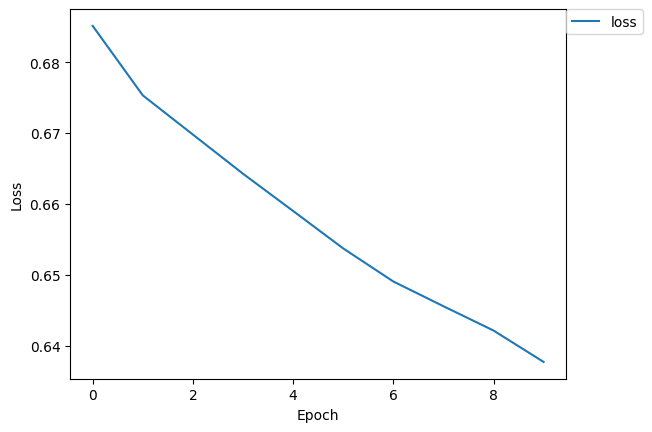

In [40]:

plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(bbox_to_anchor=(1, 1),loc='upper left', borderaxespad=0)

## V. Use the model

Now that our model has been trained, we can use it to generate text. As mentioned earlier, to do so we have to keep track of its internal state, or memory, so that we can use previous text predictions to inform later ones.

However, with RNN generated text, if we always just pick the character with the highest probability, our model tends to get stuck in a loop. So instead we will create a probability distribution of characters for each step, and then sample from that distribution. We can add some variation to this using a paramter known as ["temperature"](https://cs.stackexchange.com/questions/79241/what-is-temperature-in-lstm-and-neural-networks-generally).

In [41]:
# Here's the code we'll use to sample for us. It has some extra steps to apply
# the temperature to the distribution, and to make sure we don't get empty
# characters in our text. Most importantly, it will keep track of our model
# state for us.

class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature=temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask,validate_indices=False)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature

    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Return the characters and model state.
    return chars_from_ids(predicted_ids), states


In [42]:
# Create an instance of the character generator
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

# Now, let's generate a 1000 character chapter by giving our model "Chapter 1"
# as its starting text
states = None
next_char = tf.constant(['Chapter 1'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)

# Print the results formatted.
print(result[0].numpy().decode('utf-8'))




Chapter 13


Marianne's intention of the delightful picture remained; neither could
you know without fortune, and very civil serious amazement;--as far as
all this was, that Edward had been very far from its effects, it would
be by nettige when a large house of mind fully shut off in the same to
Mansfield.

“Oh yes! me if you cannot deny us just now; for Mr. Rushworth is so easily
recovered, has nothing to keep my agitated man-lets than affact.

She first returned, though steadily tendered in these people, whatever
lived, of course only to consider him still more, but her answer was
instantly yet anxious to oblige herself, and as few perecting which
sprung from her aunt Bertram and Marianne, she thought she had got a little
in love of for ten days, that Marger had made Henry’s instructions, he
had a hackney to in to say she had been stronger understood.--He
confessed that she had felt almost as might ten that house when passed
at last, however disappointment was almost always injuring 

In [43]:
model.save('20_epoch_base_model_lstm-1-c')

INFO:tensorflow:Assets written to: 20_epoch_base_model_lstm-1-c\assets


INFO:tensorflow:Assets written to: 20_epoch_base_model_lstm-1-c\assets


## VI. Next Steps

This is a very simple model with one GRU layer and then an output layer. However, considering how simple it is and the fact that we are predicting outputs character by character, the text it produces is pretty amazing. Though it still has a long way to go before publication.

There are many other RNN architectures you could try, such as adding additional hidden dense layers, replacing GRU with one or more LSTM layers, combining GRU and LSTM, etc...

You could also experiment with better text cleanup to make sure odd punctuation doesn't appear, or finding longer texts to use. If you combine texts from two authors, what happens? Can you generate a Jane Austen stageplay by combining austen and shakespeare texts?

Finally, there are a number of hyperparameters to tweak, such as temperature, epochs, batch size, sequence length, etc...